<a href="https://colab.research.google.com/github/CIRdata/538_Riddler_Submissions/blob/master/538_Riddler_20200103_The_Vexing_Vexillology_Express.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below is my submission for the Riddler Express, published on 2020-01-03

Results:
* Flag A = France
* Flag B = Brazil
* Flag C = Namibia

See: https://fivethirtyeight.com/features/can-you-solve-the-vexing-vexillology/

From the website: 


*Riddler Express*

*From Jason Zimba comes a sequence of scrambled screens:*

*Each of the images below is a different nation’s flag in which the pixels have been randomly rearranged. Can you figure out which flag is which?*

*Important note: Some browsers can distort the colors of the flags. If you’d like to scrutinize these images, consider downloading them first, which you can do by right-clicking each image.*

*There will be one winner per flag. And if you’re a little rusty on your flags, you can view them all here.*





In [0]:
!pip install wget >nul 2>&1
import wget
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import urllib.request

%matplotlib inline

In [0]:
#links to our scrambled flags
scrambled_flags={}
scrambled_flags['A'] = 'https://fivethirtyeight.com/wp-content/uploads/2020/01/flag_1.png?w=498'
scrambled_flags['B'] = 'https://fivethirtyeight.com/wp-content/uploads/2020/01/flag_2.png?w=414'
scrambled_flags['C'] = 'https://fivethirtyeight.com/wp-content/uploads/2020/01/flag_3.png?w=496'


In [0]:
def color_class(R,G,B,A):
  #classify the colors for beter sorting
  if R>G*1.1 and R>B*1.1 and R>80:
    #red
    r = 1
  elif G>R*1.1 and G>B*1.1 and G>80:
    #green
    r = 2
  elif B>R*1.1 and B>G*1.1 and B>80:
    #blue
    r = 3
  elif R>B*1.1 and G>B*1.1 and R>50:
    #yellow
    r = 4
  elif G>R*1.1 and B>R*1.1 and B>50:
    #cyan
    r = 5
  elif R>G*1.1 and B>G*1.1 and B>50:
    #magenta
    r = 6
  else:
    #black/white
    r = 7
    
  return r

In [0]:
def get_flag_rgb(filename,url):
  
  #download the file if it hasn't already been downloaded
  if os.path.exists(filename) == False:
    wget.download(url,out=filename)



  flag_pic = imageio.imread(filename)

  h=flag_pic.shape[0]
  w=flag_pic.shape[1]
  #some pics are RGBA, and others are RGB, if d=3, then its RGB, else its RGBA
  d=flag_pic.shape[2]

  #reshaping from an array with picture pixles as rows/columns and color (rgb[a]) 
  #as depth to an array where each row is a pixle and columns are rgb[a]
  pic_list = flag_pic.transpose(2,0,1).reshape(d,-1).transpose(1,0)
  pic_df = pd.DataFrame(pic_list)
  
  if d == 3:
    pic_df.columns=['R','G','B']
    pic_df['sort']=np.vectorize(color_class)(pic_df['R'],pic_df['G'],pic_df['B'],255)
  else:
    pic_df.columns=['R','G','B','A']
    pic_df['sort']=np.vectorize(color_class)(pic_df['R'],pic_df['G'],pic_df['B'],pic_df['A'])
  
  #grouping by color
  pic_df_grp = pic_df.groupby(['R','G','B']).agg({'R':'count'})
  pic_df_grp.columns = ['cnt']
  pic_df_grp['percent'] = pic_df_grp['cnt']/float(len(pic_df))
  pic_df_grp = pic_df_grp.reset_index()

  #taking the average color
  pic_df_avg = pic_df.mean()
  r = {}

  #sort the picture elements by the color class and then the RGB values
  pic_df_sorted = pic_df.sort_values(['sort','R','G','B'])[['R','G','B']].values.transpose(1,0).reshape(-1,h,w).transpose(1,2,0)

  r['grp'] = pic_df_grp
  r['all'] = pic_df
  r['sorted'] = pic_df_sorted
  r['avg'] = pic_df_avg
  r['original']=flag_pic
  
  return r




In [0]:

def color_dist(rgb_t, rgb_c):
  #calculate the distance between two RGB colors
  return ((rgb_t[0]-rgb_c[0])**2+(rgb_t[1]-rgb_c[1])**2+(rgb_t[2]-rgb_c[2])**2)**0.5


In [0]:
#this website has all of the flags of the world (fotw)
url_flags = 'https://www.cia.gov/library/publications/the-world-factbook/docs/flagsoftheworld.html'
fotw = urllib.request.urlopen(url_flags)
fotw_html = fotw.read().decode("utf8")
fotw.close()

fotw_str = str(fotw_html)

prev_s = 0

#s = the start position for searching
#in the html, 'flag appendix-entry ln-' appears a short dist before each flag file name
s = fotw_str.find('flag appendix-entry ln-')
flag_dict = {}
import time
while s != -1:
  #looking up the image file names
  img_tag_st = 'src="'
  img_tag_end = '" />'
  img_st = fotw_str[s:].find(img_tag_st)+s+26
  img_end = fotw_str[s:].find(img_tag_end)+s
  img_name = fotw_str[img_st:img_end]

  #looking up the associated country names
  country_tag_st="<div class='flag-description'><span>"
  country_tag_end="</span></div>"
  country_st = fotw_str[s:].find(country_tag_st)+len(country_tag_st)+s
  country_end = fotw_str[country_st:].find(country_tag_end)+country_st
  country_name = fotw_str[country_st:country_end]
  #breaks once we stop finding new country flags
  if len(country_name) == 0:
    break
  flag_dict[country_name]=img_name
  
  #looks for the next tag to start looking from
  s = fotw_str[country_end:].find('flag appendix-entry ln-')+country_end+5
  

  


In [0]:
#download the flags for each country from the fotw site and calculate the rgb properties
url_root='https://www.cia.gov/library/publications/the-world-factbook/attachments/flags/'
flag_colors_dict = {}
for country in flag_dict:
  filename = flag_dict[country]
  flag_colors_dict[country] = get_flag_rgb(filename,url_root+filename)

In [0]:
flag_scrambled_dict = {}
for fname in scrambled_flags:
  flag_scrambled_dict[fname] = get_flag_rgb(fname,scrambled_flags[fname])

In [0]:

#for each scrabled flag, calculatet he distance between it's average RGB
#color and each of the flags average RGB downloaded from the fotw site
for x in flag_colors_dict:
  flag_colors_dict[x]['A Dist'] = color_dist(list(flag_colors_dict[x]['avg'][0:3]),list(flag_scrambled_dict['A']['avg'][0:3]))
  flag_colors_dict[x]['B Dist'] = color_dist(list(flag_colors_dict[x]['avg'][0:3]),list(flag_scrambled_dict['B']['avg'][0:3]))
  flag_colors_dict[x]['C Dist'] = color_dist(list(flag_colors_dict[x]['avg'][0:3]),list(flag_scrambled_dict['C']['avg'][0:3]))

In [0]:
#put the results in a dataframe
res = {}
for x in flag_colors_dict:
  res[x]=[flag_colors_dict[x]['A Dist'], flag_colors_dict[x]['B Dist'], flag_colors_dict[x]['C Dist']]
res_df = pd.DataFrame(res).transpose()
res_df.columns = ['A','B','C']

Text(0.5, 1.0, '3rd Best Match on Avg Color - Sorted - Saint Barthelemy')

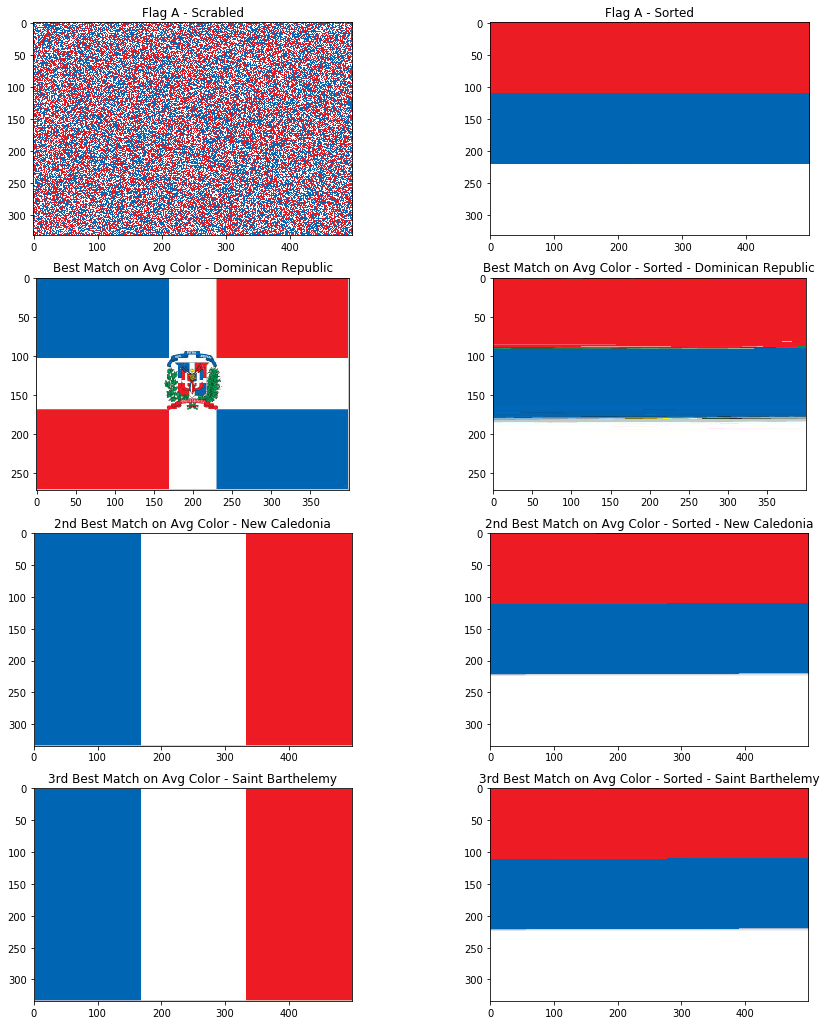

In [11]:
fig, ax = plt.subplots(4,2, figsize=(15,18))

ax[0,0].imshow(flag_scrambled_dict['A']['original'])
ax[0,0].set_title('Flag A - Scrabled')

ax[0,1].imshow(flag_scrambled_dict['A']['sorted'])
ax[0,1].set_title('Flag A - Sorted')

ax[1,0].imshow(flag_colors_dict[res_df.sort_values(['A']).index[0]]['original'])
ax[1,0].set_title('Best Match on Avg Color - '+res_df.sort_values(['A']).index[0])

ax[1,1].imshow(flag_colors_dict[res_df.sort_values(['A']).index[0]]['sorted'])
ax[1,1].set_title('Best Match on Avg Color - Sorted - '+res_df.sort_values(['A']).index[0])

ax[2,0].imshow(flag_colors_dict[res_df.sort_values(['A']).index[1]]['original'])
ax[2,0].set_title('2nd Best Match on Avg Color - '+res_df.sort_values(['A']).index[1])

ax[2,1].imshow(flag_colors_dict[res_df.sort_values(['A']).index[1]]['sorted'])
ax[2,1].set_title('2nd Best Match on Avg Color - Sorted - '+res_df.sort_values(['A']).index[1])

ax[3,0].imshow(flag_colors_dict[res_df.sort_values(['A']).index[2]]['original'])
ax[3,0].set_title('3rd Best Match on Avg Color - '+res_df.sort_values(['A']).index[2])

ax[3,1].imshow(flag_colors_dict[res_df.sort_values(['A']).index[2]]['sorted'])
ax[3,1].set_title('3rd Best Match on Avg Color - Sorted - '+res_df.sort_values(['A']).index[2])

Looking at the above flags.. they all look pretty evenly split, even though the best match based on average RGB color is DR, the other flags visually seem to have beter matches in there sorted data.

Below, looking at the counts of colors in each file, it seems the 2nd/3rd placings are closer color percent makeup.. and since the 2nd/3rd places are basically just the frech flag, I'll go with that.

In [12]:
flag_scrambled_dict['A']['grp'].sort_values(['percent'],ascending=False).head()

,R,G,B,cnt,percent
74,235,28,36,54708,0.330890
149,255,255,255,54393,0.328985
13,0,101,179,53851,0.325706
17,0,102,177,801,0.004845
86,237,30,38,162,0.000980


In [13]:
flag_colors_dict[res_df.sort_values(['A']).index[0]]['grp'].sort_values(['percent'],ascending=False).head()

,R,G,B,cnt,percent
255,255,255,255,29354,0.269798
2,0,101,179,28488,0.261838
172,237,27,36,28406,0.261085
242,254,254,254,1123,0.010322
5,0,103,185,919,0.008447


In [14]:
flag_colors_dict[res_df.sort_values(['A']).index[1]]['grp'].sort_values(['percent'],ascending=False).head()

,R,G,B,cnt,percent
87,237,28,36,54750,0.327844
130,255,255,255,54579,0.326820
13,0,102,179,54180,0.324431
12,0,102,178,810,0.004850
60,225,226,227,643,0.003850


Text(0.5, 1.0, '3rd Best Match on Avg Color - Sorted - Dominica')

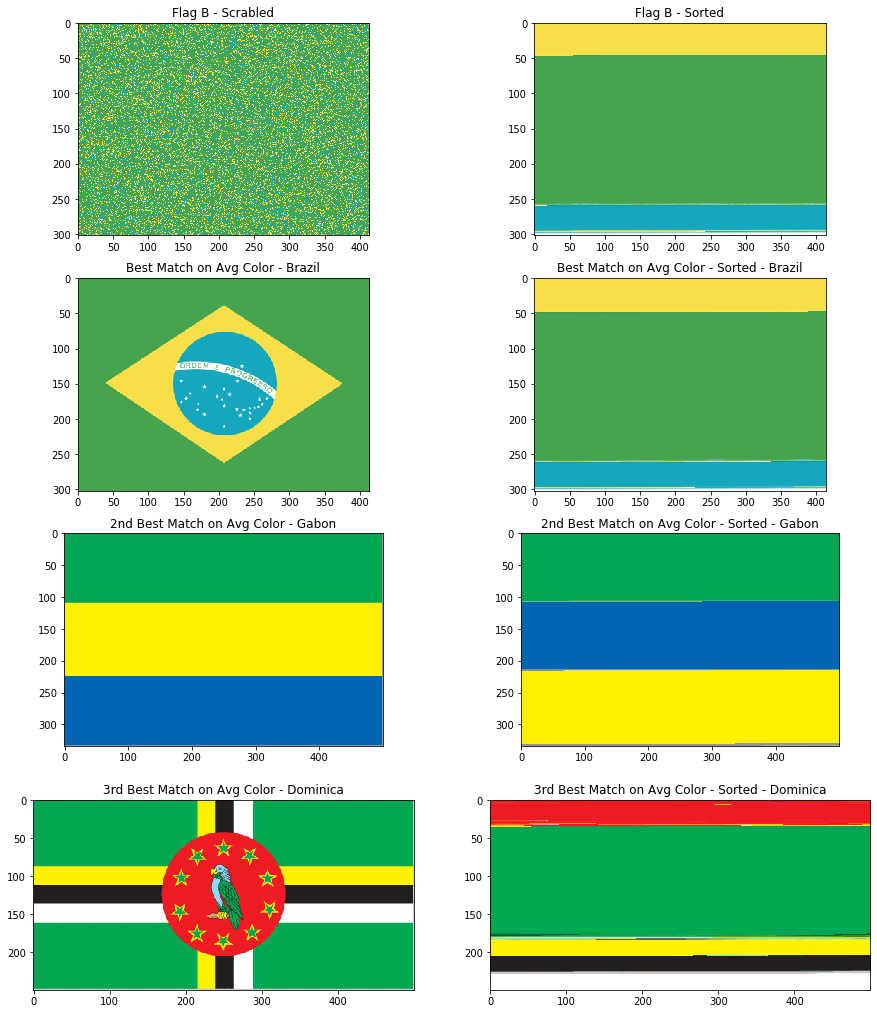

In [15]:
fig, ax = plt.subplots(4,2, figsize=(15,18))

ax[0,0].imshow(flag_scrambled_dict['B']['original'])
ax[0,0].set_title('Flag B - Scrabled')

ax[0,1].imshow(flag_scrambled_dict['B']['sorted'])
ax[0,1].set_title('Flag B - Sorted')

ax[1,0].imshow(flag_colors_dict[res_df.sort_values(['B']).index[0]]['original'])
ax[1,0].set_title('Best Match on Avg Color - '+res_df.sort_values(['B']).index[0])

ax[1,1].imshow(flag_colors_dict[res_df.sort_values(['B']).index[0]]['sorted'])
ax[1,1].set_title('Best Match on Avg Color - Sorted - '+res_df.sort_values(['B']).index[0])

ax[2,0].imshow(flag_colors_dict[res_df.sort_values(['B']).index[1]]['original'])
ax[2,0].set_title('2nd Best Match on Avg Color - '+res_df.sort_values(['B']).index[1])

ax[2,1].imshow(flag_colors_dict[res_df.sort_values(['B']).index[1]]['sorted'])
ax[2,1].set_title('2nd Best Match on Avg Color - Sorted - '+res_df.sort_values(['B']).index[1])

ax[3,0].imshow(flag_colors_dict[res_df.sort_values(['B']).index[2]]['original'])
ax[3,0].set_title('3rd Best Match on Avg Color - '+res_df.sort_values(['B']).index[2])

ax[3,1].imshow(flag_colors_dict[res_df.sort_values(['B']).index[2]]['sorted'])
ax[3,1].set_title('3rd Best Match on Avg Color - Sorted - '+res_df.sort_values(['B']).index[2])

For flag 2 Brazil seems to be a clear winner

Text(0.5, 1.0, '3rd Best Match on Avg Color - Sorted - South Africa')

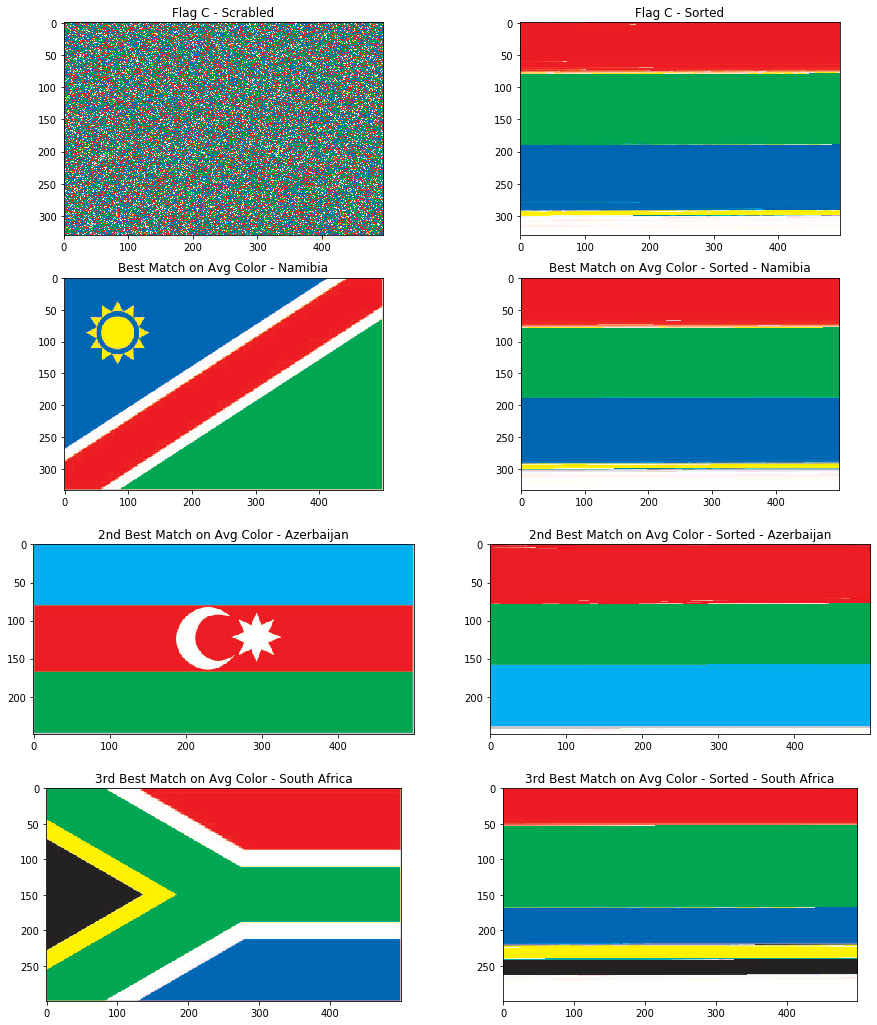

In [17]:
fig, ax = plt.subplots(4,2, figsize=(15,18))

ax[0,0].imshow(flag_scrambled_dict['C']['original'])
ax[0,0].set_title('Flag C - Scrabled')

ax[0,1].imshow(flag_scrambled_dict['C']['sorted'])
ax[0,1].set_title('Flag C - Sorted')

ax[1,0].imshow(flag_colors_dict[res_df.sort_values(['C']).index[0]]['original'])
ax[1,0].set_title('Best Match on Avg Color - '+res_df.sort_values(['C']).index[0])

ax[1,1].imshow(flag_colors_dict[res_df.sort_values(['C']).index[0]]['sorted'])
ax[1,1].set_title('Best Match on Avg Color - Sorted - '+res_df.sort_values(['C']).index[0])

ax[2,0].imshow(flag_colors_dict[res_df.sort_values(['C']).index[1]]['original'])
ax[2,0].set_title('2nd Best Match on Avg Color - '+res_df.sort_values(['C']).index[1])

ax[2,1].imshow(flag_colors_dict[res_df.sort_values(['C']).index[1]]['sorted'])
ax[2,1].set_title('2nd Best Match on Avg Color - Sorted - '+res_df.sort_values(['C']).index[1])

ax[3,0].imshow(flag_colors_dict[res_df.sort_values(['C']).index[2]]['original'])
ax[3,0].set_title('3rd Best Match on Avg Color - '+res_df.sort_values(['C']).index[2])

ax[3,1].imshow(flag_colors_dict[res_df.sort_values(['C']).index[2]]['sorted'])
ax[3,1].set_title('3rd Best Match on Avg Color - Sorted - '+res_df.sort_values(['C']).index[2])

Flag C it seems like Nambia would be the best match